# Dataframe Cleaning

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap


## 1.   Loading the Dataframe and detecting the missing values such as: (0, "N/a", "na", np.nan) ->

In [26]:
##
    #! df = pd.read_csv(url, low_memory=False, na_values = missing_values)
    #! Define dtype for columns or use low_memory=False

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64a26694-01dc-4ec3-aa87-ad8509604f50/resource/1e824947-d73b-4f48-9bac-7f7f3731a6b9/download/Fire%20Incidents%20Data.csv"
missing_values = ["N/a", "na", np.nan]
dtype_dict = {
    '_id': int,
    'Area_of_Origin': str,
    'Building_Status': str,
    'Business_Impact': str,
    'Civilian_Casualties': float,
    'Count_of_Persons_Rescued': float,
    'Estimated_Dollar_Loss': float,
    'Estimated_Number_Of_Persons_Displaced': float,
    'Exposures': float,
    'Ext_agent_app_or_defer_time': str,
    'Extent_Of_Fire': str,
    'Final_Incident_Type': str,
    'Fire_Alarm_System_Impact_on_Evacuation': str,
    'Fire_Alarm_System_Operation': str,
    'Fire_Alarm_System_Presence': str,
    'Fire_Under_Control_Time': str,
    'Ignition_Source': str,
    'Incident_Number': str,
    'Incident_Station_Area': str,
    'Incident_Ward': float,
    'Initial_CAD_Event_Type': str,
    'Intersection': str,
    'Last_TFS_Unit_Clear_Time': str,
    'Latitude': float,
    'Level_Of_Origin': str,
    'Longitude': float,
    'Material_First_Ignited': str,
    'Method_Of_Fire_Control': str,
    'Number_of_responding_apparatus': float,
    'Number_of_responding_personnel': float,
    'Possible_Cause': str,
    'Property_Use': str,
    'Smoke_Alarm_at_Fire_Origin': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Failure': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Type': str,
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation': str,
    'Smoke_Spread': str,
    'Sprinkler_System_Operation': str,
    'Sprinkler_System_Presence': str,
    'Status_of_Fire_On_Arrival': str,
    'TFS_Alarm_Time': str,
    'TFS_Arrival_Time': str,
    'TFS_Firefighter_Casualties': float
}
#
df = pd.read_csv(url, dtype=dtype_dict, na_values = missing_values)
# df = pd.read_csv(url, dtype=dtype_dict)


    #? Show missing values
# df.isnull().sum()

    #? Or in boolean format:
# df.isnull().any()

    #? Heatmap of missing values
# sns.heatmap(df.isnull(), yticklabels=False)
# sns.heatmap(df.isnull(), yticklabels=False, annot=True)

    #? 29425 rows × 43 columns with NaN
# df

## 2.   Handling the missing values ->

In [27]:
    #? Remove only the rows that are all NaN (still 29425 rows × 43 columns, no row has only NaN)
df_dropped = df.copy()
df_dropped = df_dropped.dropna(how="all")


    #? Swap all NaN values to '0'
df_dropped = df_dropped.fillna(0)
# df_dropped.isnull().any()

    #? Or swap only one row's NaN's to '0'
# df_dropped["Area_of_Origin"] = df_dropped["Area_of_Origin"].fillna(0)
# df_dropped.isnull().any()

# df_dropped

    #? This this allows calculations to be made on that dataset

## 3.   Handling Duplicates ->

In [28]:
    #? Check for Duplicates
df_dropped.duplicated()

    #? Drop all the duplicates (none on this case still 29425 rows × 43 columns)
df_dropped.drop_duplicates(keep="first", inplace=True)
# df_dropped

## 4.   Handling Dates ->

In [29]:
date_columns = ['TFS_Alarm_Time', 'Fire_Under_Control_Time', 'Last_TFS_Unit_Clear_Time', 'TFS_Arrival_Time', 'Ext_agent_app_or_defer_time']
for col in date_columns:
    df_dropped[col] = pd.to_datetime(df_dropped[col], errors='coerce')
# df_dropped.info()
# df_dropped

## 5.   Changing types ->

In [30]:
change_cols = ["TFS_Firefighter_Casualties", "Civilian_Casualties", "Count_of_Persons_Rescued", "Number_of_responding_personnel", "Number_of_responding_apparatus", "Exposures"]

for col in change_cols:
    df_dropped[col] = df_dropped[col].astype(int)

# df_dropped.dtypes

# Pre-processing Data for K-Means

## 1. Dropping the zero '0' values

In [31]:
    #? Going to drop rows where Latitude and Longtitude are 0 because won't need them.
# Longitude = Geographical length of nearest major or minor intersection in the ward of the incident
# Latitude = Geographical width of the nearest major or minor intersection in the periphery of the incident

# df_dropped = df_dropped.dropna(subset=['Latitude', 'Longitude']) # - for NaN
df_dropped = df_dropped[(df_dropped['Latitude'] != 0) & (df_dropped['Longitude'] != 0)]
# df_dropped

## 2. Calculating the number of clusters 'k' for K-Means using the elbow method ->

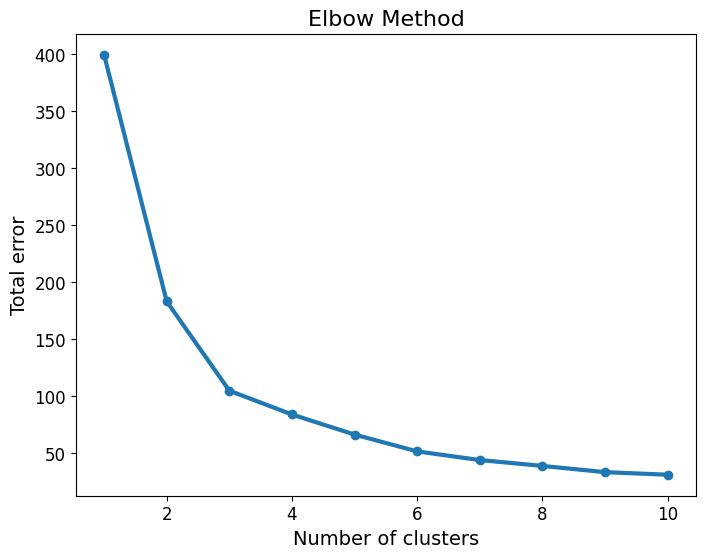

In [32]:
#? Calculate total error for different numbers of clusters with K-Means
err_total = []
n_clusters = 10

df_elbow = df_dropped[['Latitude', 'Longitude']]

for i in range(1, n_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_elbow)
    err_total.append(kmeans.inertia_)

# Plot 
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range(1, n_clusters + 1), err_total, linewidth=3, marker='o')
ax.set_xlabel("Number of clusters", fontsize=14)
ax.set_ylabel("Total error", fontsize=14)
ax.set_title("Elbow Method", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### *Based on the Elbow method, I can see that the "elbow" is on the number 3 so I am going to use k = 3  

## 3. K-Means with k = 3 ->

In [33]:
# Running K-Means with 3 clusters on Latitude and Longtitude
df_kmeans = df_dropped[['Latitude', 'Longitude']]

kmeans = KMeans(n_clusters=3, random_state=0)
df_dropped['Cluster'] = kmeans.fit_predict(df_kmeans)
centroids = kmeans.cluster_centers_

## 4. Plot for K-Means with k=3 (Lat/Lon)

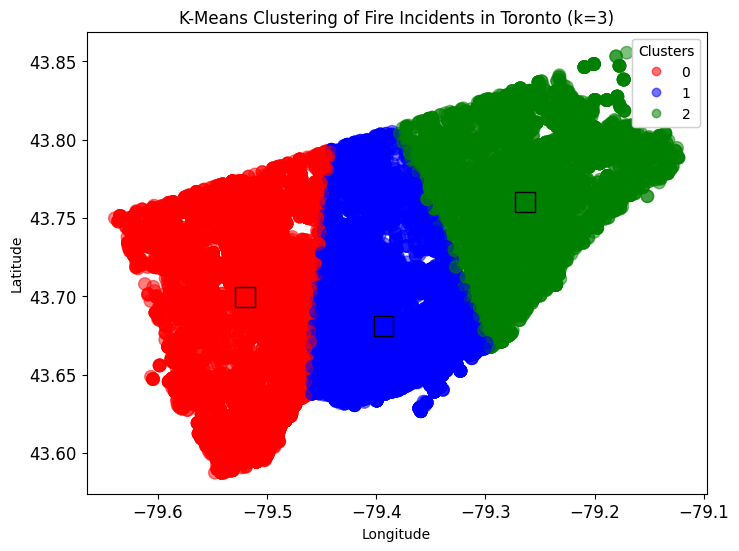

In [34]:
# Visualization using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))

# Define a custom colormap for clusters
customcmap = ListedColormap(['red', 'blue', 'green'])

# Plot the clustered data points
scatter = ax.scatter(df_dropped['Longitude'], df_dropped['Latitude'], 
c=df_dropped['Cluster'], cmap=customcmap, s=80, alpha=0.5)

# Plot the centroids
ax.scatter(centroids[:, 1], centroids[:, 0], 
marker='s', s=200, c=[0, 1, 2], cmap=customcmap, edgecolor='black')

# Set title and labels
ax.set_title('K-Means (k=3) - Geo Length / Width - Fire Incidents in Toronto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show color legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# To CSV

In [ ]:
# # Save the cleaned dataset to a CSV file
# cleaned_file_path = 'cleaned_fire_incidents.csv'
# df_dropped.to_csv(cleaned_file_path, index=False)

# print(f"Cleaned dataset has been saved to {cleaned_file_path}")